In [22]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, year, month, dayofmonth, dayofweek, weekofyear, avg, lag, when
from pyspark.sql.window import Window

In [2]:
spark = SparkSession.builder.appName("AirQualityAnalysisIndia").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/10/11 03:36:56 WARN Utils: Your hostname, Karthikeya, resolves to a loopback address: 127.0.1.1; using 10.146.5.189 instead (on interface wlp1s0)
25/10/11 03:36:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/11 03:36:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
df_filled = spark.read.parquet('file:///home/karthikeya/Desktop/sem5/MIT_SEM5_BDA/MiniProject/processed/cleaned_air_quality.parquet')

In [5]:
df_filled.groupBy("City").count().orderBy("count", ascending=False).show(10)

+-------------+-----+
|         City|count|
+-------------+-----+
|      Chennai| 2009|
|      Lucknow| 2009|
|       Mumbai| 2009|
|    Ahmedabad| 2009|
|        Delhi| 2009|
|    Bengaluru| 2009|
|    Hyderabad| 2006|
|        Patna| 1858|
|     Gurugram| 1679|
|Visakhapatnam| 1462|
+-------------+-----+
only showing top 10 rows


In [7]:
df_filled.groupBy("City").avg("PM25").orderBy("avg(PM25)", ascending=False).show(10)

+------------+------------------+
|        City|         avg(PM25)|
+------------+------------------+
|       Delhi|117.12781483325044|
|    Gurugram|110.81614651578315|
|       Patna|110.54996770721232|
|     Lucknow|106.60866600298674|
|    Guwahati| 63.65527888446214|
|     Kolkata| 63.29439803439806|
|   Ahmedabad| 61.82003982080687|
|Brajrajnagar| 60.99907249466969|
|     Talcher|58.848237837838006|
|    Amritsar| 54.74307125307148|
+------------+------------------+
only showing top 10 rows


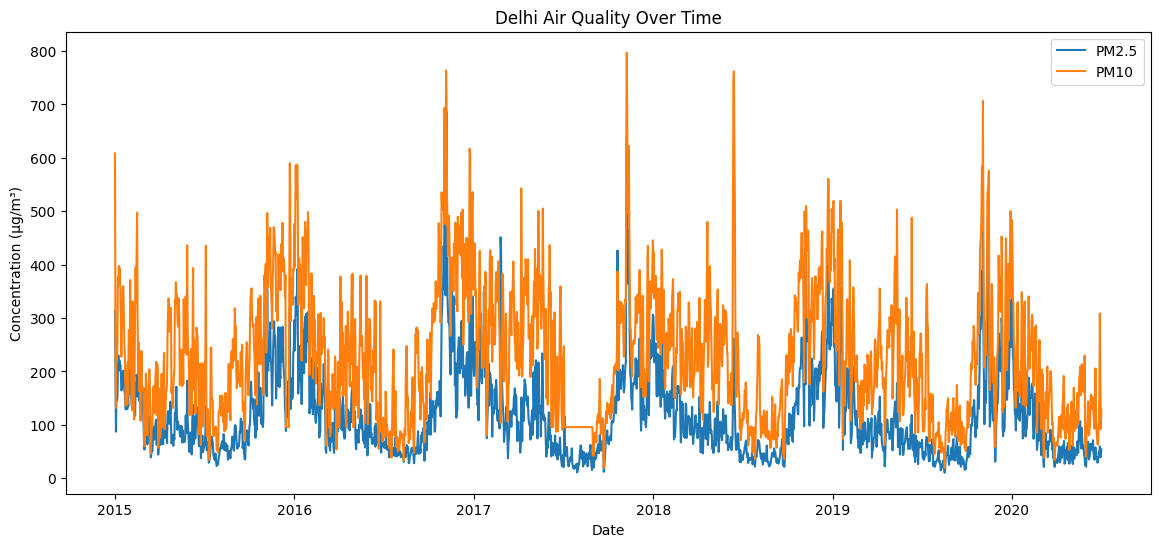

In [16]:
delhi_df = df_filled.filter(col("City") == "Delhi").select("Date", "PM25", "PM10").orderBy("Date")
delhi_pd = delhi_df.toPandas()

plt.figure(figsize=(14,6))
plt.plot(delhi_pd['Date'], delhi_pd['PM25'], label='PM2.5')
plt.plot(delhi_pd['Date'], delhi_pd['PM10'], label='PM10')
plt.title('Delhi Air Quality Over Time')
plt.xlabel('Date')
plt.ylabel('Concentration (µg/m³)')
plt.legend()
plt.show()

In [18]:
df_fe = df_filled.withColumn("year", year("Date")).withColumn("month", month("Date")).withColumn("day", dayofmonth("Date")).withColumn("dayofweek", dayofweek("Date")).withColumn("weekofyear", weekofyear("Date"))

In [21]:
window_spec = Window.partitionBy("City").orderBy("Date")

df_fe = df_fe.withColumn("pm2_5_rolling_avg_3", avg("PM25").over(window_spec.rowsBetween(-2, 0)))

df_fe = df_fe.withColumn("pm2_5_lag_1", lag("PM25", 1).over(window_spec))

In [24]:
df_fe = df_fe.withColumn("pm2_5_category", 
    when(df_fe["PM25"] <= 30, "Good")
    .when((df_fe["PM25"] > 30) & (df_fe["PM25"] <= 60), "Satisfactory")
    .when((df_fe["PM25"] > 60) & (df_fe["PM25"] <= 90), "Moderate")
    .when((df_fe["PM25"] > 90) & (df_fe["PM25"] <= 120), "Poor")
    .when((df_fe["PM25"] > 120) & (df_fe["PM25"] <= 250), "Very Poor")
    .otherwise("Severe")
)

In [25]:
weather_df = spark.read.csv('file:///home/karthikeya/Desktop/sem5/MIT_SEM5_BDA/MiniProject/datasets/air_quality_data/weather_india.csv', header=True, inferSchema=True)

25/10/11 03:45:54 WARN FileStreamSink: Assume no metadata directory. Error while looking for metadata directory in the path: file:///home/karthikeya/Desktop/sem5/MIT_SEM5_BDA/MiniProject/datasets/air_quality_data/weather_india.csv.
java.io.FileNotFoundException: File file:/home/karthikeya/Desktop/sem5/MIT_SEM5_BDA/MiniProject/datasets/air_quality_data/weather_india.csv does not exist
	at org.apache.hadoop.fs.RawLocalFileSystem.deprecatedGetFileStatus(RawLocalFileSystem.java:917)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileLinkStatusInternal(RawLocalFileSystem.java:1238)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileStatus(RawLocalFileSystem.java:907)
	at org.apache.hadoop.fs.FilterFileSystem.getFileStatus(FilterFileSystem.java:462)
	at org.apache.spark.sql.execution.streaming.FileStreamSink$.hasMetadata(FileStreamSink.scala:56)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:381)
	at org.apache.spark.sql.catalyst.analysis.ResolveDa

AnalysisException: [PATH_NOT_FOUND] Path does not exist: file:/home/karthikeya/Desktop/sem5/MIT_SEM5_BDA/MiniProject/datasets/air_quality_data/weather_india.csv. SQLSTATE: 42K03

In [27]:
df_fe.write.mode("overwrite").parquet("file:///home/karthikeya/Desktop/sem5/MIT_SEM5_BDA/MiniProject/processed/enriched_air_quality.parquet")

In [28]:
spark.stop()